In [48]:
!pip install pyalgotrade

In [49]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
import  pandas as pd

In [51]:
path = "/content/drive/MyDrive/trader/data_2020_2023_5min.csv"
df = pd.read_csv(path)

In [52]:
df['datetime'] = pd.to_datetime(df['datetime']).dt.strftime('%Y-%m-%dT%H:%M:%S.000Z')

In [53]:
df1 = df.rename(columns={
    'datetime': 'Date Time',
    'open': 'Open',
    'high': 'High',
    'low': 'Low',
    'close': 'Close',
    'volume': 'Volume'
})

In [54]:
df1.head()

,Date Time,Open,High,Low,Close,Volume
0,2020-01-01T05:30:00.000Z,7195.24,7196.25,7178.64,7179.78,95.509133
1,2020-01-01T05:35:00.000Z,7179.76,7191.77,7178.20,7191.07,59.365225
2,2020-01-01T05:40:00.000Z,7193.15,7193.53,7180.24,7180.97,48.068510
3,2020-01-01T05:45:00.000Z,7180.97,7186.40,7177.35,7178.29,32.192929
4,2020-01-01T05:50:00.000Z,7177.71,7182.46,7175.47,7176.96,49.027397


In [55]:
df1.to_csv('data.csv', index=False)

In [56]:
from pyalgotrade import strategy
from pyalgotrade.barfeed import csvfeed
from pyalgotrade.broker import backtesting
from pyalgotrade import plotter
import datetime

In [57]:
from pyalgotrade.technical import macd

London Breakout Startegy Pair  with MACD startegy

In [58]:
class RollingWindow(object):
    def __init__(self, windowSize):
        self.__values = []
        self.__windowSize = windowSize
    def onNewValue(self, value):
        self.__values.append(value)
        if len(self.__values) > self.__windowSize:
            self.__values.pop(0)
    def getValues(self):
        return self.__values
    def getHighest(self):
        if len(self.__values) == 0:
            return None
        return max(self.__values)
    def getLowest(self):
        if len(self.__values) == 0:
            return None
        return min(self.__values)

In [59]:
class LondonBreakoutMACDStrategy(strategy.BacktestingStrategy):
    def __init__(self, feed, instrument, broker, takeProfitMultiplier, stopMultiplier):
        super(LondonBreakoutMACDStrategy, self).__init__(feed, broker)
        self.__instrument = instrument
        self.__takeProfitMultiplier = takeProfitMultiplier
        self.__stopMultiplier = stopMultiplier
        self.__position = None
        self.__takeProfitPrice = None
        self.__stopPrice = None
        self.__macd = macd.MACD(feed[instrument].getCloseDataSeries(), 12, 26, 9)
        self.__london_open = datetime.time(8, 0)
        self.__london_close = datetime.time(9, 0)

    def onBars(self, bars):
        bar = bars[self.__instrument]
        current_time = bar.getDateTime().time()

        if current_time > self.__london_close:
            if self.__position is None:
                macd_value = self.__macd[-1]
                signal_value = self.__macd.getSignal()[-1]

                if macd_value is None or signal_value is None:
                    return

                if macd_value > signal_value:
                    self.__position = self.enterLong(self.__instrument, 1, True)
                    self.__takeProfitPrice = bar.getPrice() * (1 + self.__takeProfitMultiplier)
                    self.__stopPrice = bar.getPrice() * (1 - self.__stopMultiplier)

                elif macd_value < signal_value:
                    self.__position = self.enterShort(self.__instrument, 1, True)
                    self.__takeProfitPrice = bar.getPrice() * (1 - self.__takeProfitMultiplier)
                    self.__stopPrice = bar.getPrice() * (1 + self.__stopMultiplier)

            else:
                if self.__position.getShares() > 0:
                    if bar.getPrice() >= self.__takeProfitPrice or bar.getPrice() <= self.__stopPrice:
                        self.__position.exitMarket()
                        self.__position = None
                elif self.__position.getShares() < 0:
                    if bar.getPrice() <= self.__takeProfitPrice or bar.getPrice() >= self.__stopPrice:
                        self.__position.exitMarket()
                        self.__position = None

Final Portfolio Value:  1454139.3882999984


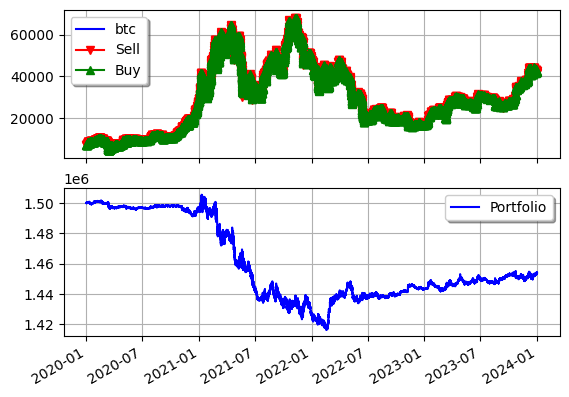

In [60]:
def run_london_breakout_macd_strategy(tp, stop):
    feed = csvfeed.GenericBarFeed(frequency=60 * 5)
    feed.setDateTimeFormat("%Y-%m-%dT%H:%M:%S.%fZ")
    feed.addBarsFromCSV("btc", "data.csv")

    commission = backtesting.TradePercentage(0.0001)
    broker = backtesting.Broker(1500000, feed, commission)

    myStrategy = LondonBreakoutMACDStrategy(feed, "btc", broker, tp, stop)
    plt = plotter.StrategyPlotter(myStrategy)
    myStrategy.run()

    final_value = myStrategy.getResult()
    print("Final Portfolio Value: ", final_value)
    plt.plot()

run_london_breakout_macd_strategy(0.018, 0.003)


Bollinger Bands Strategy

In [61]:
from pyalgotrade.technical import ma

In [62]:
from pyalgotrade import strategy
from pyalgotrade.barfeed import csvfeed
from pyalgotrade.broker import backtesting
from pyalgotrade import plotter
from pyalgotrade.technical import bollinger

In [63]:
from pyalgotrade import strategy
from pyalgotrade.barfeed import csvfeed
from pyalgotrade.broker import backtesting
from pyalgotrade import plotter
from pyalgotrade.technical import bollinger
import datetime
class BollingerBandsStrategy(strategy.BacktestingStrategy):

    def __init__(self, feed, instrument, broker, windowSize, numStdDev, takeProfitMultiplier, stopMultiplier):
        super(BollingerBandsStrategy, self).__init__(feed, broker)
        self.__instrument = instrument
        self.__position = None
        self.__takeProfitPrice = None
        self.__stopPrice = None
        self.__bb = bollinger.BollingerBands(feed[self.__instrument].getCloseDataSeries(), windowSize, numStdDev)
        self.__takeProfitMultiplier = takeProfitMultiplier
        self.__stopMultiplier = stopMultiplier

    def onBars(self, bars):
        bar = bars[self.__instrument]
        close_price = bar.getClose()

        upper_band = self.__bb.getUpperBand()[-1]
        lower_band = self.__bb.getLowerBand()[-1]

        if upper_band is None or lower_band is None:
            return
        if self.__position is None:
            if close_price > upper_band:
                self.__position = self.enterLong(self.__instrument, 1, True)
                self.__takeProfitPrice = close_price * (1 + self.__takeProfitMultiplier)
                self.__stopPrice = close_price * (1 - self.__stopMultiplier)

            elif close_price < lower_band:
                self.__position = self.enterShort(self.__instrument, 1, True)
                self.__takeProfitPrice = close_price * (1 - self.__takeProfitMultiplier)
                self.__stopPrice = close_price * (1 + self.__stopMultiplier)

        else:
            if self.__position.getShares() > 0:
                if close_price >= self.__takeProfitPrice or close_price <= self.__stopPrice:
                    self.__position.exitMarket()
                    self.__position = None
            elif self.__position.getShares() < 0:
                if close_price <= self.__takeProfitPrice or close_price >= self.__stopPrice:
                    self.__position.exitMarket()
                    self.__position = None


INFO:strategy:Final portfolio value: $1383433.5579290043
2024-09-29 18:47:12,478 strategy [INFO] Final portfolio value: $1383433.5579290043


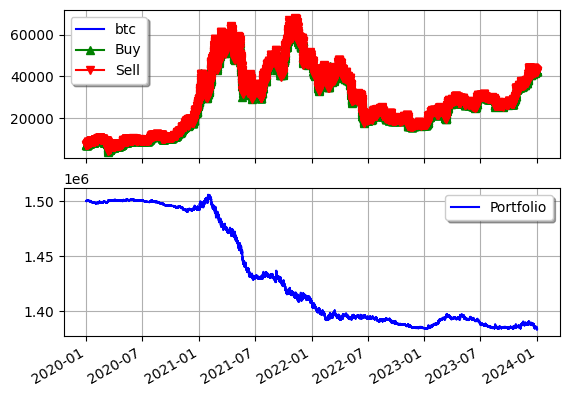

In [64]:

def run_bollinger_bands_strategy(tp, stop):
    feed = csvfeed.GenericBarFeed(frequency=60 * 5)
    feed.setDateTimeFormat("%Y-%m-%dT%H:%M:%S.%fZ")
    feed.addBarsFromCSV("btc", "data.csv")

    commission = backtesting.TradePercentage(0.0001)
    broker = backtesting.Broker(1500000, feed, commission)

    myStrategy = BollingerBandsStrategy(feed, "btc", broker, windowSize=20, numStdDev=2, takeProfitMultiplier=tp, stopMultiplier=stop)

    plt = plotter.StrategyPlotter(myStrategy)

    myStrategy.run()
    myStrategy.info(f'Final portfolio value: ${myStrategy.getResult()}')

    plt.plot()

run_bollinger_bands_strategy(0.018, 0.003)

Pair Trading

In [65]:
class PairTradingStrategy(strategy.BacktestingStrategy):
    def __init__(self, feed, instrument1, instrument2, broker, fastMA, slowMA, takeProfitMultiplier, stopMultiplier):
        super(PairTradingStrategy, self).__init__(feed, broker)
        self.__instrument1 = instrument1
        self.__instrument2 = instrument2
        self.__fast_ma1 = ma.SMA(feed[instrument1].getPriceDataSeries(), fastMA)
        self.__slow_ma1 = ma.SMA(feed[instrument1].getPriceDataSeries(), slowMA)
        self.__fast_ma2 = ma.SMA(feed[instrument2].getPriceDataSeries(), fastMA)
        self.__slow_ma2 = ma.SMA(feed[instrument2].getPriceDataSeries(), slowMA)
        self.__takeProfitMultiplier = takeProfitMultiplier
        self.__stopMultiplier = stopMultiplier
        self.__position = None
        self.__lastTrend = None
        self.__takeProfitPrice1 = None
        self.__takeProfitPrice2 = None
        self.__stopPrice1 = None
        self.__stopPrice2 = None
    def getFastSMA1(self):
        return self.__fast_ma1

    def getSlowSMA1(self):
        return self.__slow_ma1

    def getFastSMA2(self):
        return self.__fast_ma2

    def getSlowSMA2(self):
        return self.__slow_ma2

    def onBars(self, bars):
        if (self.__fast_ma1[-1] is None or self.__slow_ma1[-1] is None or
            self.__fast_ma2[-1] is None or self.__slow_ma2[-1] is None):
            return

        bar1 = bars[self.__instrument1]
        bar2 = bars[self.__instrument2]
        if self.__position is None:
            if self.__fast_ma1[-1] > self.__slow_ma1[-1] and self.__fast_ma2[-1] < self.__slow_ma2[-1]:
                self.__position = self.enterLong(self.__instrument1, 1, True)
                self.enterShort(self.__instrument2, 1, True)
                self.__takeProfitPrice1 = bar1.getPrice() * (1 + self.__takeProfitMultiplier)
                self.__stopPrice1 = bar1.getPrice() * (1 - self.__stopMultiplier)
                self.__takeProfitPrice2 = bar2.getPrice() * (1 - self.__takeProfitMultiplier)
                self.__stopPrice2 = bar2.getPrice() * (1 + self.__stopMultiplier)
            elif self.__fast_ma1[-1] < self.__slow_ma1[-1] and self.__fast_ma2[-1] > self.__slow_ma2[-1]:
                self.__position = self.enterShort(self.__instrument1, 1, True)
                self.enterLong(self.__instrument2, 1, True)
                self.__takeProfitPrice1 = bar1.getPrice() * (1 - self.__takeProfitMultiplier)
                self.__stopPrice1 = bar1.getPrice() * (1 + self.__stopMultiplier)
                self.__takeProfitPrice2 = bar2.getPrice() * (1 + self.__takeProfitMultiplier)
                self.__stopPrice2 = bar2.getPrice() * (1 - self.__stopMultiplier)
        else:
            if self.__position.getShares() > 0:
                if (bar1.getPrice() >= self.__takeProfitPrice1 or
                    bar1.getPrice() <= self.__stopPrice1):
                    self.__position.exitMarket()
                    self.__position = None
                if (bar2.getPrice() <= self.__takeProfitPrice2 or
                    bar2.getPrice() >= self.__stopPrice2):
                    self.__position.exitMarket()
                    self.__position = None

            elif self.__position.getShares() < 0:
                if (bar1.getPrice() <= self.__takeProfitPrice1 or
                    bar1.getPrice() >= self.__stopPrice1):
                    self.__position.exitMarket()
                    self.__position = None

                if (bar2.getPrice() >= self.__takeProfitPrice2 or
                    bar2.getPrice() <= self.__stopPrice2):
                    self.__position.exitMarket()
                    self.__position = None


INFO:strategy:Final portfolio value: $1500000
2024-09-29 18:48:53,110 strategy [INFO] Final portfolio value: $1500000


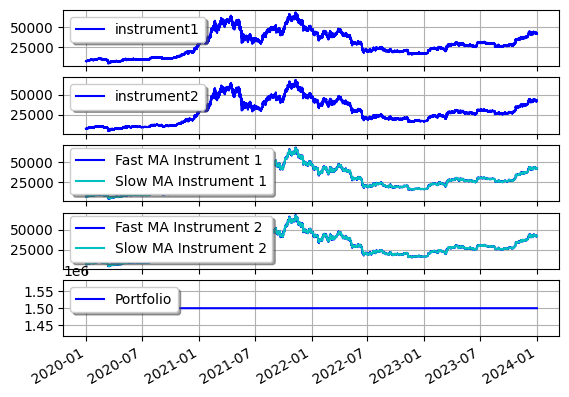

In [66]:
def run_pair_trading_strategy(fastSma, slowSma, tp, stop):
    feed = csvfeed.GenericBarFeed(frequency=60*5)
    feed.setDateTimeFormat("%Y-%m-%dT%H:%M:%S.%fZ")
    feed.addBarsFromCSV("instrument1", "data.csv")
    feed.addBarsFromCSV("instrument2", "data.csv")
    commission = backtesting.TradePercentage(0.0001)
    broker = backtesting.Broker(1500000, feed, commission)
    myStrategy = PairTradingStrategy(feed, "instrument1", "instrument2", broker, fastSma, slowSma, tp, stop)
    plt = plotter.StrategyPlotter(myStrategy)
    plt.getOrCreateSubplot("MA_Instrument1").addDataSeries("Fast MA Instrument 1", myStrategy.getFastSMA1())
    plt.getOrCreateSubplot("MA_Instrument1").addDataSeries("Slow MA Instrument 1", myStrategy.getSlowSMA1())
    plt.getOrCreateSubplot("MA_Instrument2").addDataSeries("Fast MA Instrument 2", myStrategy.getFastSMA2())
    plt.getOrCreateSubplot("MA_Instrument2").addDataSeries("Slow MA Instrument 2", myStrategy.getSlowSMA2())
    myStrategy.run()
    myStrategy.info(f'Final portfolio value: ${myStrategy.getResult()}')
    plt.plot()

run_pair_trading_strategy(50, 200, 0.018, 0.003)

Elliot wave startegy

In [67]:
import numpy as np


In [68]:
class ElliottWaveStrategy(strategy.BacktestingStrategy):
    def __init__(self, feed, instrument, broker):
        super(ElliottWaveStrategy, self).__init__(feed, broker)
        self.__instrument = instrument
        self.__position = None
        self.__prices = []
        self.__highs = []
        self.__lows = []

    def onBars(self, bars):
        bar = bars[self.__instrument]
        self.__prices.append(bar.getPrice())
        self.__highs.append(bar.getHigh())
        self.__lows.append(bar.getLow())
        if len(self.__prices) > 50:
            self.__prices.pop(0)
            self.__highs.pop(0)
            self.__lows.pop(0)

        wave_is_bullish = self.identify_bullish_wave()
        wave_is_bearish = self.identify_bearish_wave()
        if self.__position is None and wave_is_bullish:
            self.__position = self.enterLong(self.__instrument, 1, True)
        elif self.__position is None and wave_is_bearish:
            self.__position = self.enterShort(self.__instrument, 1, True)
        elif self.__position is not None and self.__position.getShares() > 0 and wave_is_bearish:
            self.__position.exitMarket()
            self.__position = None
        elif self.__position is not None and self.__position.getShares() < 0 and wave_is_bullish:
            self.__position.exitMarket()
            self.__position = None

    def identify_bullish_wave(self):
        last_10_highs = self.__highs[-10:] if len(self.__highs) >= 10 else self.__highs
        last_10_lows = self.__lows[-10:] if len(self.__lows) >= 10 else self.__lows

        higher_high = np.all(np.diff(last_10_highs) > 0)
        higher_low = np.all(np.diff(last_10_lows) > 0)

        return higher_high and higher_low

    def identify_bearish_wave(self):
        last_10_highs = self.__highs[-10:] if len(self.__highs) >= 10 else self.__highs
        last_10_lows = self.__lows[-10:] if len(self.__lows) >= 10 else self.__lows

        lower_high = np.all(np.diff(last_10_highs) < 0)
        lower_low = np.all(np.diff(last_10_lows) < 0)

        return lower_high and lower_low

INFO:strategy:Final portfolio value: $1459332.6099639994
2024-09-29 18:50:31,070 strategy [INFO] Final portfolio value: $1459332.6099639994


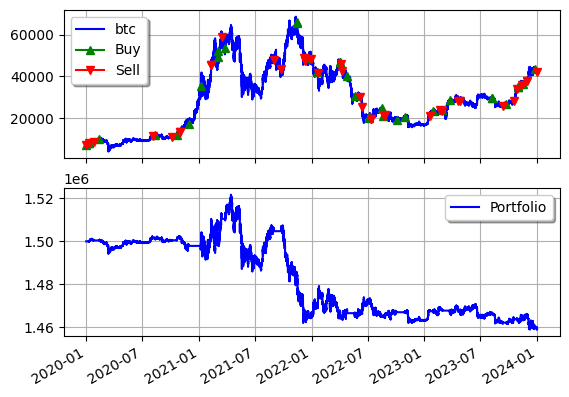

In [69]:

def run_strategy():
    feed = csvfeed.GenericBarFeed(frequency=60*5)
    feed.setDateTimeFormat("%Y-%m-%dT%H:%M:%S.%fZ")
    feed.addBarsFromCSV("btc", "data.csv")
    commission = backtesting.TradePercentage(0.0001)
    broker = backtesting.Broker(1500000, feed, commission)
    myStrategy = ElliottWaveStrategy(feed, "btc", broker)
    plt = plotter.StrategyPlotter(myStrategy)
    myStrategy.run()
    myStrategy.info(f'Final portfolio value: ${myStrategy.getResult()}')
    plt.plot()
run_strategy()

Final Portfolio Value:  1503618.200474


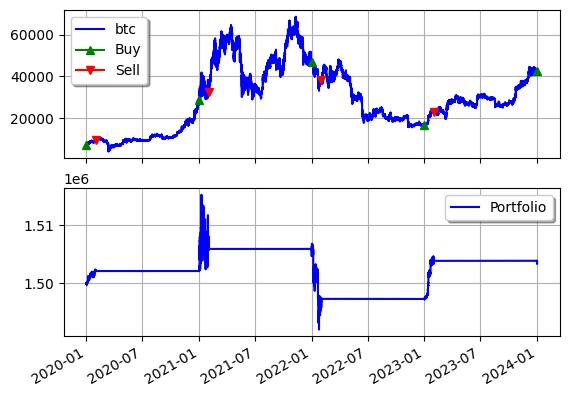

Final Portfolio Value:  1517071.025057


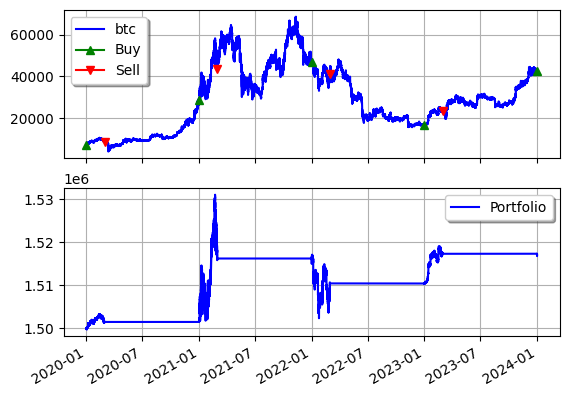

Final Portfolio Value:  1540449.1370120002


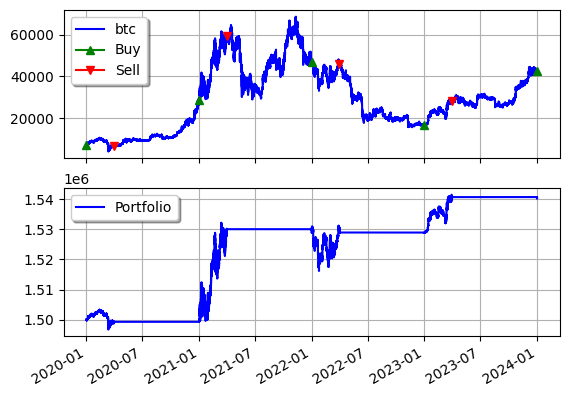

Final Portfolio Value:  1533463.9156040002


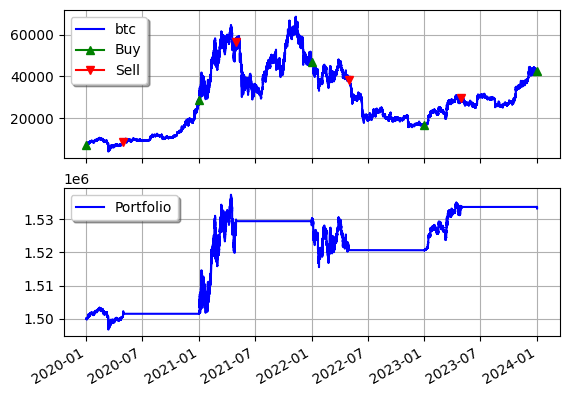

Final Portfolio Value:  1505509.2713480003


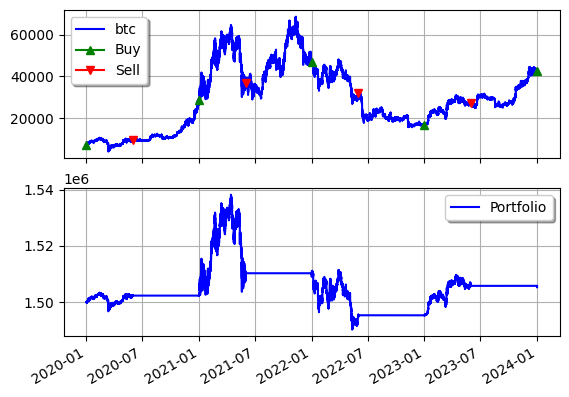

Final Portfolio Value:  1493445.087887


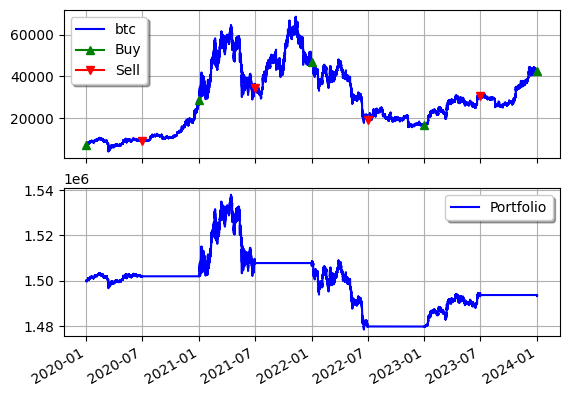

Final Portfolio Value:  1505598.972377


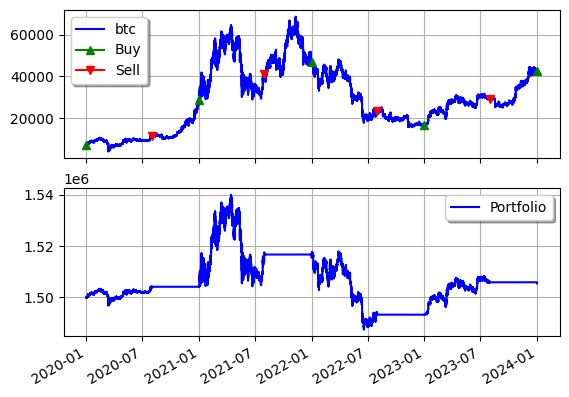

Final Portfolio Value:  1505479.344341


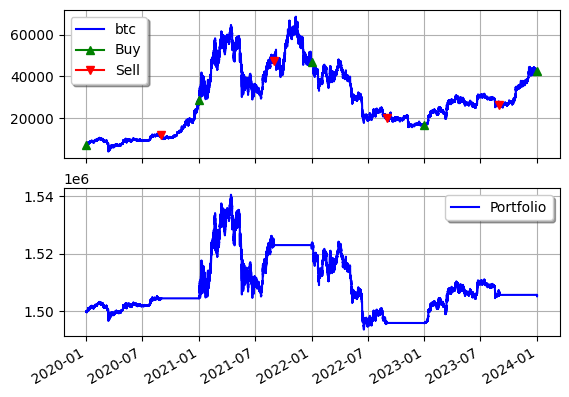

Final Portfolio Value:  1501248.417476


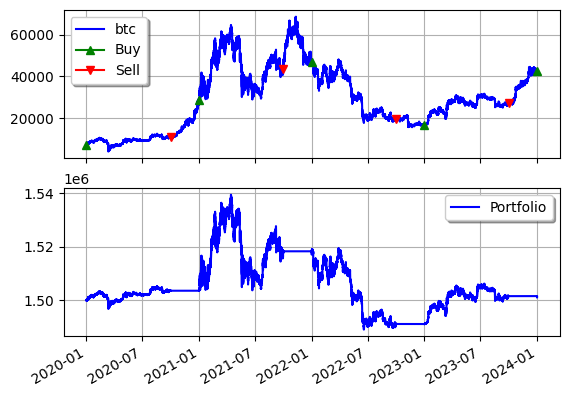

Final Portfolio Value:  1529228.2792100003


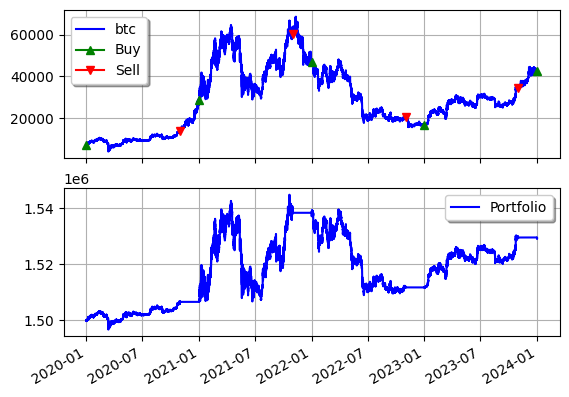

Final Portfolio Value:  1531794.4625660002


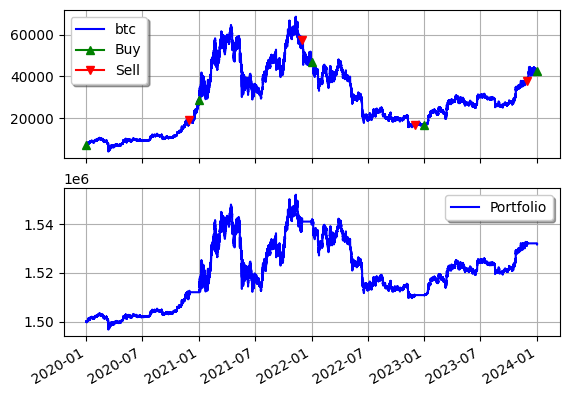

Final Portfolio Value:  1513432.150505


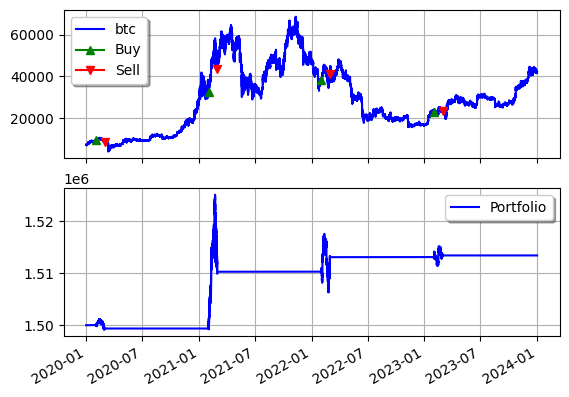

Final Portfolio Value:  1536810.26246


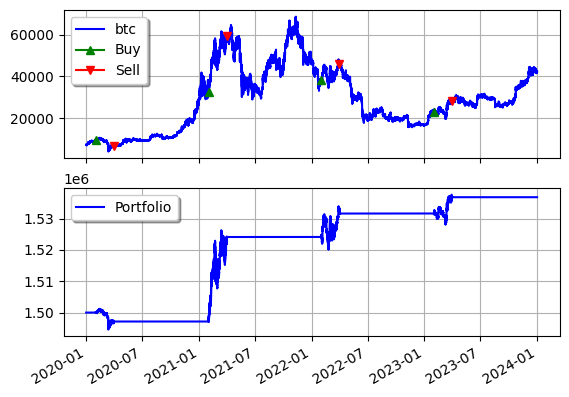

Final Portfolio Value:  1529825.0410520001


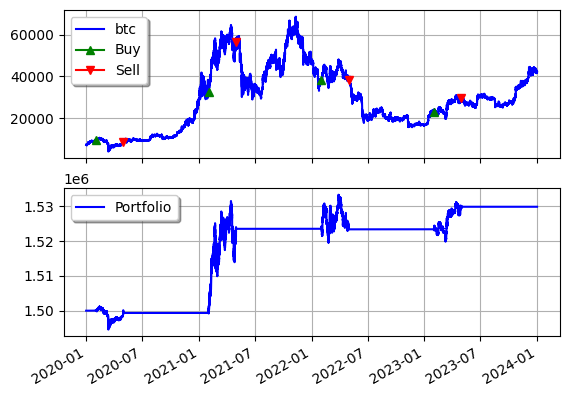

Final Portfolio Value:  1501870.3967960002


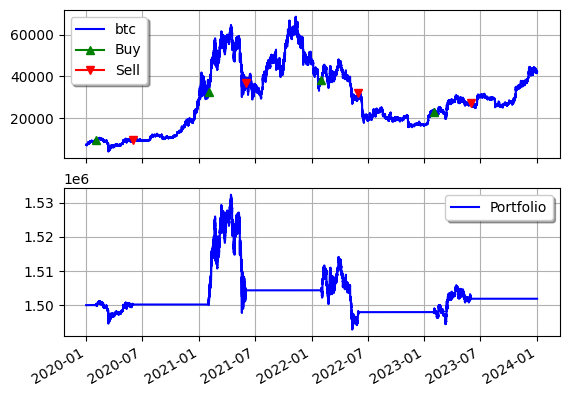

Final Portfolio Value:  1489806.213335


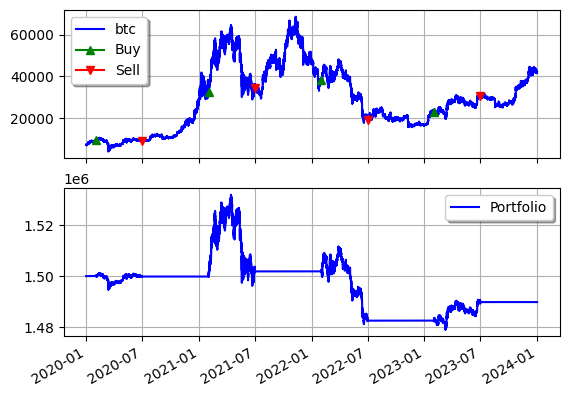

Final Portfolio Value:  1501960.0978249998


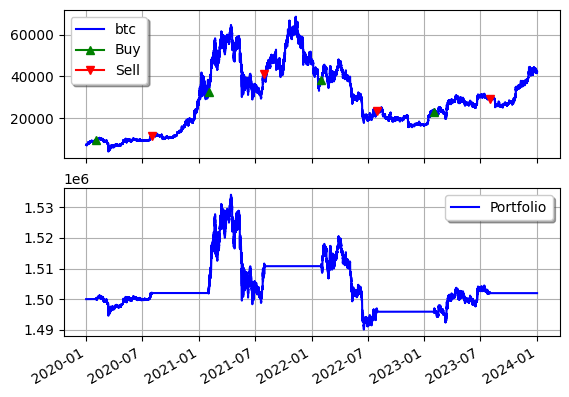

Final Portfolio Value:  1501840.469789


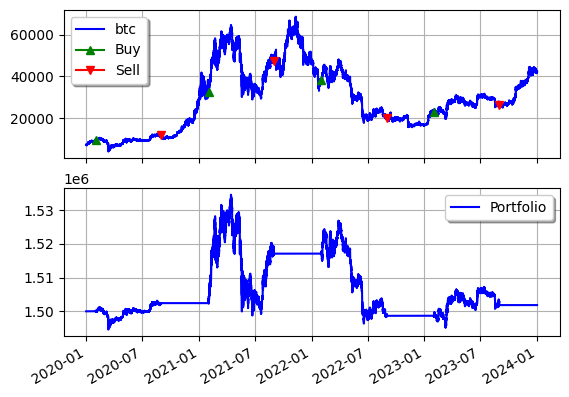

Final Portfolio Value:  1497609.542924


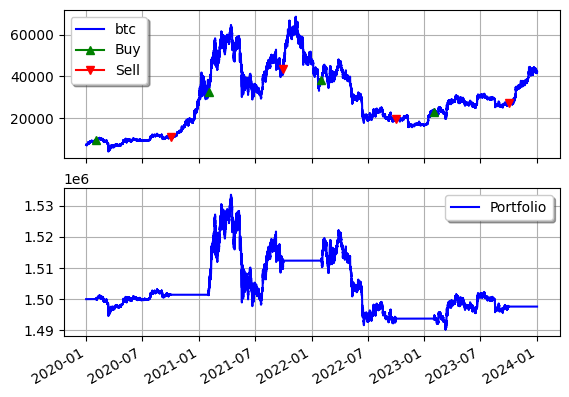

Final Portfolio Value:  1525589.4046580002


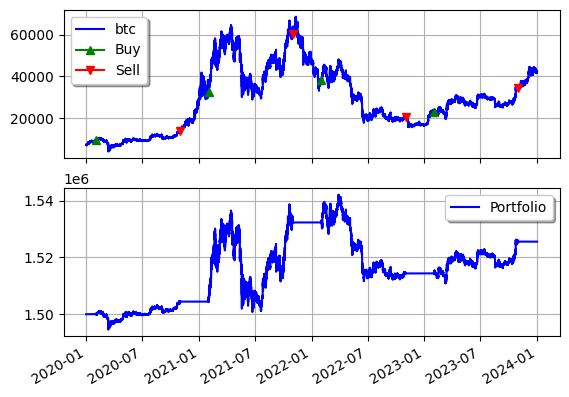

Final Portfolio Value:  1528155.588014


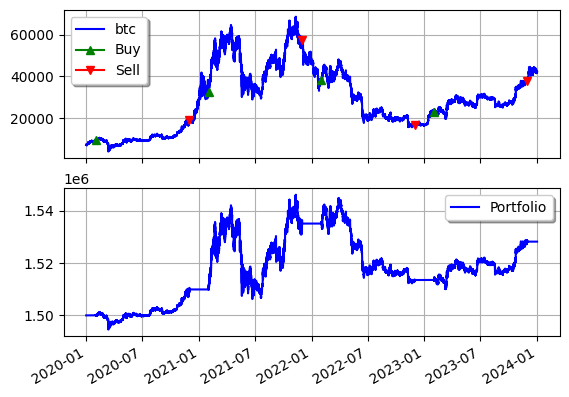

Final Portfolio Value:  1523354.747043


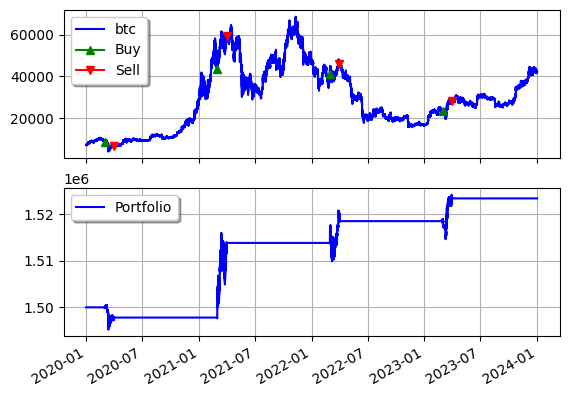

Final Portfolio Value:  1516369.525635


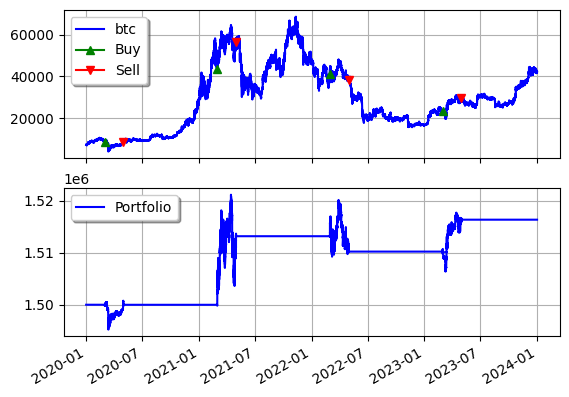

Final Portfolio Value:  1488414.8813790001


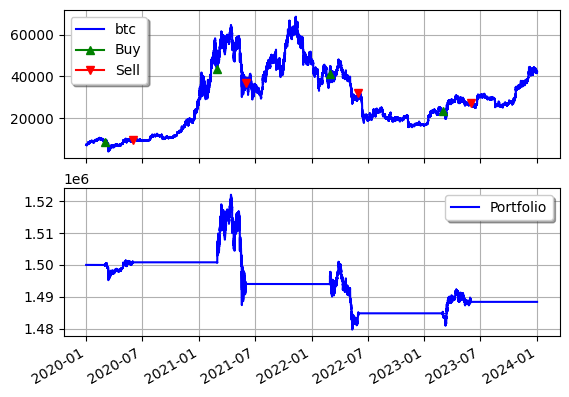

Final Portfolio Value:  1476350.697918


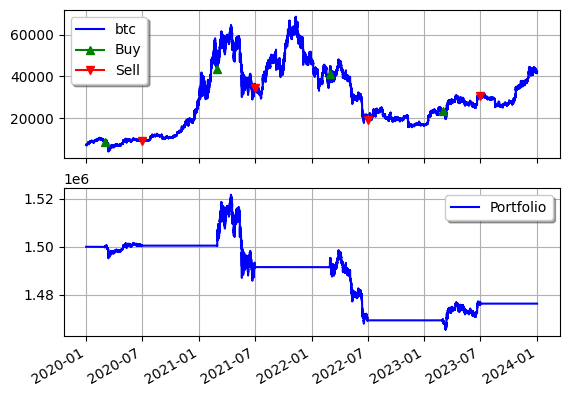

Final Portfolio Value:  1488504.5824079998


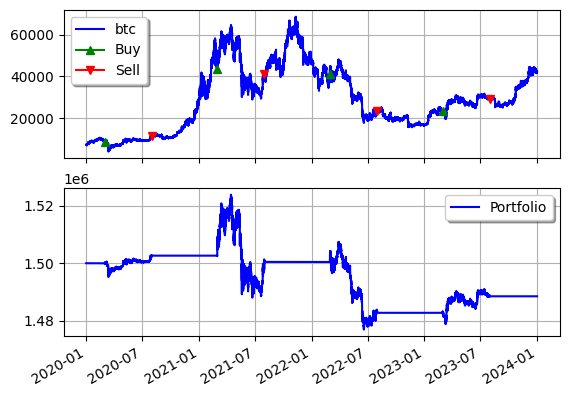

Final Portfolio Value:  1488384.954372


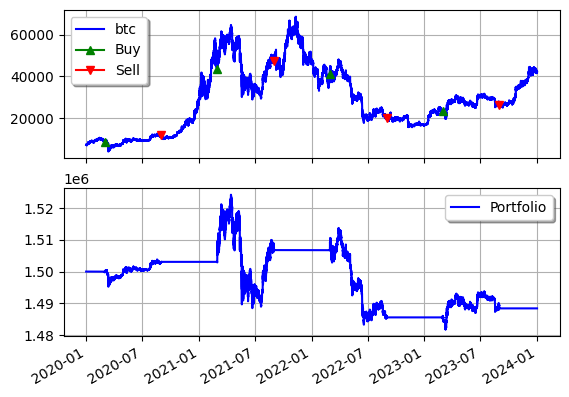

KeyboardInterrupt: 

In [73]:
from pyalgotrade import strategy
from pyalgotrade.barfeed import csvfeed
from pyalgotrade.broker import backtesting
from pyalgotrade import plotter

class SeasonalityStrategy(strategy.BacktestingStrategy):

    def __init__(self, feed, instrument, broker, buyMonth, sellMonth):
        super(SeasonalityStrategy, self).__init__(feed, broker)
        self.__instrument = instrument
        self.__position = None
        self.__buyMonth = buyMonth
        self.__sellMonth = sellMonth

    def onBars(self, bars):
        bar = bars[self.__instrument]
        currentMonth = bar.getDateTime().month

        # Buy if we are in the buying month
        if self.__position is None and currentMonth == self.__buyMonth:
            self.__position = self.enterLong(self.__instrument, 1, True)

        # Sell if we are in the selling month
        elif self.__position is not None and currentMonth == self.__sellMonth:
            self.__position.exitMarket()
            self.__position = None

def run_strategy(buyMonth, sellMonth):
    feed = csvfeed.GenericBarFeed(frequency=60*5)
    feed.setDateTimeFormat("%Y-%m-%dT%H:%M:%S.%fZ")
    feed.addBarsFromCSV("btc", "data.csv")
    commission = backtesting.TradePercentage(0.0001)
    broker = backtesting.Broker(1500000, feed, commission)
    myStrategy = SeasonalityStrategy(feed, "btc", broker, buyMonth=buyMonth, sellMonth=sellMonth)
    plt = plotter.StrategyPlotter(myStrategy)
    myStrategy.run()

    final_value = myStrategy.getResult()
    print("Final Portfolio Value: ", final_value)
    plt.plot()
for i in range(1, 13):
    for j in range(1, 13):
        if i < j:
            run_strategy(buyMonth=i, sellMonth=j)
        break;

INFO:strategy:Final portfolio value: $1478729.727517007
2024-09-29 19:31:36,462 strategy [INFO] Final portfolio value: $1478729.727517007


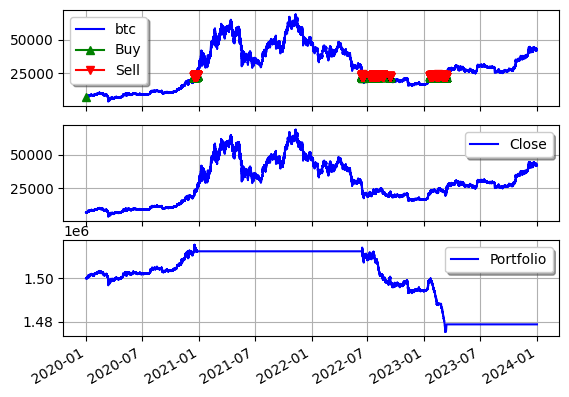

In [74]:
class FibonacciRetracementStrategy(strategy.BacktestingStrategy):
    def __init__(self, feed, instrument, low, high, broker):
        super(FibonacciRetracementStrategy, self).__init__(feed, broker)
        self.__instrument = instrument
        self.__low = low
        self.__high = high
        self.__position = None
        self.__fibonacci_levels = self.calculate_fibonacci_levels()

    def calculate_fibonacci_levels(self):
        return {
            "level1": self.__high - (self.__high - self.__low) * 0.236,
            "level2": self.__high - (self.__high - self.__low) * 0.382,
            "level3": self.__high - (self.__high - self.__low) * 0.618,
        }

    def onBars(self, bars):
        current_price = bars[self.__instrument].getClose()
        if self.__position is None and current_price <= self.__fibonacci_levels["level1"]:
            self.__position = self.enterLong(self.__instrument, 1, True)
        elif self.__position is not None and current_price >= self.__fibonacci_levels["level3"]:
            self.__position.exitMarket()
            self.__position = None

def run_fibonacci_strategy(low, high):
    feed = csvfeed.GenericBarFeed(frequency=60*5)
    feed.setDateTimeFormat("%Y-%m-%dT%H:%M:%S.%fZ")
    feed.addBarsFromCSV("btc", "data.csv")

    commission = backtesting.TradePercentage(0.0001)
    broker = backtesting.Broker(1500000, feed, commission)

    myStrategy = FibonacciRetracementStrategy(feed, "btc", low, high, broker)

    plt = plotter.StrategyPlotter(myStrategy)
    plt.getOrCreateSubplot("Price").addDataSeries("Close", feed["btc"].getPriceDataSeries())

    myStrategy.run()
    myStrategy.info(f'Final portfolio value: ${myStrategy.getResult()}')

    plt.plot()

run_fibonacci_strategy(low=20000, high=25000)


INFO:strategy:Final portfolio value: $1526789.8071280012
2024-09-29 19:34:50,082 strategy [INFO] Final portfolio value: $1526789.8071280012


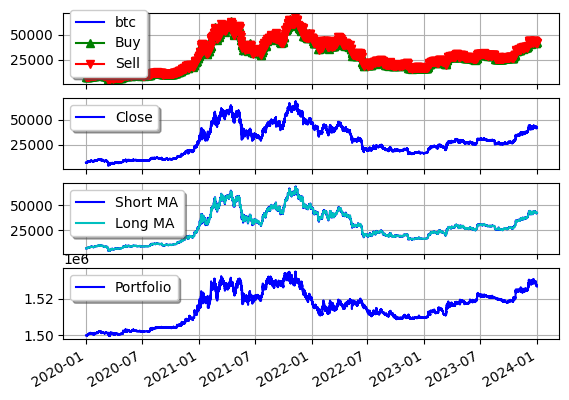

In [79]:
class MovingAverageCrossover(strategy.BacktestingStrategy):
    def __init__(self, feed, instrument, shortPeriod, longPeriod, broker):
        super(MovingAverageCrossover, self).__init__(feed, broker)
        self.__instrument = instrument
        self._shortMA = ma.SMA(feed[instrument].getPriceDataSeries(), shortPeriod)
        self._longMA = ma.SMA(feed[instrument].getPriceDataSeries(), longPeriod)
        self.__position = None

    def onBars(self, bars):
        if self._shortMA[-1] is None or self._longMA[-1] is None:
            return

        current_price = bars[self.__instrument].getClose()

        if self.__position is None and self._shortMA[-1] > self._longMA[-1]:
            self.__position = self.enterLong(self.__instrument, 1, True)

        elif self.__position is not None and self._shortMA[-1] < self._longMA[-1]:
            self.__position.exitMarket()
            self.__position = None

def run_crossover_strategy(shortPeriod, longPeriod):
    feed = csvfeed.GenericBarFeed(frequency=60*5)
    feed.setDateTimeFormat("%Y-%m-%dT%H:%M:%S.%fZ")
    feed.addBarsFromCSV("btc", "data.csv")

    commission = backtesting.TradePercentage(0.0001)
    broker = backtesting.Broker(1500000, feed, commission)

    myStrategy = MovingAverageCrossover(feed, "btc", shortPeriod, longPeriod, broker)

    plt = plotter.StrategyPlotter(myStrategy)
    plt.getOrCreateSubplot("Price").addDataSeries("Close", feed["btc"].getPriceDataSeries())
    plt.getOrCreateSubplot("MA").addDataSeries("Short MA", myStrategy._shortMA)
    plt.getOrCreateSubplot("MA").addDataSeries("Long MA", myStrategy._longMA)

    myStrategy.run()
    myStrategy.info(f'Final portfolio value: ${myStrategy.getResult()}')

    plt.plot()

# Example usage
run_crossover_strategy(shortPeriod=50, longPeriod=200)

DEBUG:broker.backtesting:Not enough volume to fill btc market order [7649] for 1 share/s
2020-02-19 17:05:00 broker.backtesting [DEBUG] Not enough volume to fill btc market order [7649] for 1 share/s
DEBUG:broker.backtesting:Not enough volume to fill btc market order [61951] for 1 share/s
2021-02-11 07:50:00 broker.backtesting [DEBUG] Not enough volume to fill btc market order [61951] for 1 share/s
DEBUG:broker.backtesting:Not enough volume to fill btc market order [61951] for 1 share/s
2021-02-11 07:55:00 broker.backtesting [DEBUG] Not enough volume to fill btc market order [61951] for 1 share/s
DEBUG:broker.backtesting:Not enough volume to fill btc market order [61951] for 1 share/s
2021-02-11 08:00:00 broker.backtesting [DEBUG] Not enough volume to fill btc market order [61951] for 1 share/s
DEBUG:broker.backtesting:Not enough volume to fill btc market order [61951] for 1 share/s
2021-02-11 08:05:00 broker.backtesting [DEBUG] Not enough volume to fill btc market order [61951] for 1 

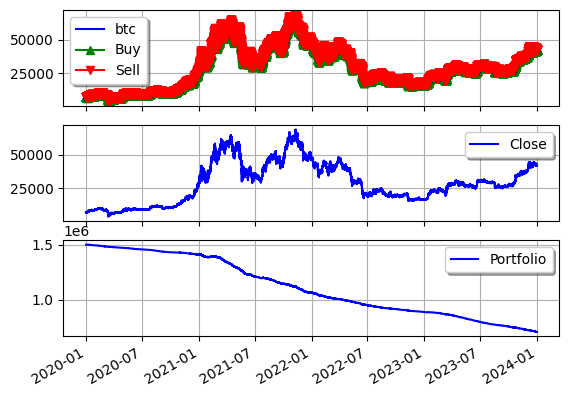

In [82]:
class PriceActionStrategy(strategy.BacktestingStrategy):
    def __init__(self, feed, instrument, broker):
        super(PriceActionStrategy, self).__init__(feed, broker)
        self.__instrument = instrument
        self.__position = None
        self.__lastClose = None

    def onBars(self, bars):
        current_price = bars[self.__instrument].getClose()
        if self.__lastClose is not None:
            if self.__position is None and current_price > self.__lastClose:
                self.__position = self.enterLong(self.__instrument, 1, True)
            elif self.__position is not None and current_price < self.__lastClose:
                self.__position.exitMarket()
                self.__position = None
        self.__lastClose = current_price

def run_price_action_strategy():
    feed = csvfeed.GenericBarFeed(frequency=60*5)
    feed.setDateTimeFormat("%Y-%m-%dT%H:%M:%S.%fZ")
    feed.addBarsFromCSV("btc", "data.csv")

    commission = backtesting.TradePercentage(0.0001)
    broker = backtesting.Broker(1500000, feed, commission)

    myStrategy = PriceActionStrategy(feed, "btc", broker)

    plt = plotter.StrategyPlotter(myStrategy)
    plt.getOrCreateSubplot("Price").addDataSeries("Close", feed["btc"].getPriceDataSeries())

    myStrategy.run()
    myStrategy.info(f'Final portfolio value: ${myStrategy.getResult()}')

    plt.plot()

run_price_action_strategy()